In [1]:
from platform import python_version

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# factor analysis mixed data types
import prince
from sklearn.decomposition import PCA
# seed
RANDOM_STATE = 1776

# set seaborn theme
sns.set_theme()

# print versions
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)
print("Matplotlib Version: " + plt.matplotlib.__version__)
print("Python Version: " + python_version())
print("Prince Version: " + prince.__version__)

# adjust pandas display options to max
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# adjust pandas display options to ensure full display of content
pd.set_option('display.max_colwidth', None)

Numpy Version: 1.26.4
Pandas Version: 2.2.3
Seaborn Version: 0.13.2
Matplotlib Version: 3.9.2
Python Version: 3.9.20
Prince Version: 0.13.0


### Import Data

In [2]:
# full dataframe
df = pd.read_pickle("../Data/CleanFullLabelsML.pkl")

# data dictionary
df_dict = pd.read_pickle("../Data/FinalcolumnDefinitionML.pkl")

# data label
df_label = pd.read_pickle("../Data/colLabelML.pkl") 

# boolean
df_bool = pd.read_pickle("../Data/colBooleanML.pkl")

# nominal
df_nominal = pd.read_pickle("../Data/colNominalML.pkl")

# ordinal
df_ordinal = pd.read_pickle("../Data/colOrdinalML.pkl")

# numeric
df_numeric = pd.read_pickle("../Data/colNumericML.pkl")

# checking for duplicated column name
df.columns[df.columns.duplicated()]

Index([], dtype='object')

#### Data Shape

In [3]:
# df DataFrame
print(f"Orginal Data file Shape: {df.shape}")
print(f"Label(s) Data rows: {len(df_label)}")
print(f"Boolean(s) Data rows: {len(df_bool)}")
print(f"Ordinal(s) Data rows: {len(df_ordinal)}")
print(f"Nominal(s) Data rows: {len(df_nominal)}")
print(f"Numeric(s) Data rows: {len(df_numeric)}")

Orginal Data file Shape: (14856, 121)
Label(s) Data rows: 13
Boolean(s) Data rows: 9
Ordinal(s) Data rows: 15
Nominal(s) Data rows: 79
Numeric(s) Data rows: 18


### User Function(s):

In [4]:
def percentageNull(datadf):
    """
    Calculate percentage of NaN & NaN count
    """
    # calculate the percentage of non-null values for each column
    per_calc = pd.DataFrame(100 - (datadf.count() / len(datadf) * 100))
    
    # rename columns name
    per_calc.rename(columns={0: 'percentage'}, inplace=True)

    # add counter
    per_calc['NaNCount'] = datadf.isna().sum()
    
    # sort
    per_calc.sort_values(by='percentage', inplace=True, ascending=False)

    # 
    NanReturn = per_calc[per_calc.NaNCount != 0]
    
    return NanReturn


def DefinitionSearch(datadic, col, flag=False):
    # initialize variable
    parm =  "r'(?i)" + col + "'" # regex search using ignore case sensitivity
    parm = eval(parm)
    # display
    df_str = datadic.loc[:,['featureName','desc', 'dataType', 'labelSAS', 'COMMENT', 'Information']][datadic.featureName.str.contains(parm)]

    if flag:
        feature = datadic.featureName[datadic.featureName.str.contains(parm)].tolist()
        return feature
    else:
        return df_str
    
    
def removeColumn(datadf, col):
    """
    Remove unwanted columns
    """
    # display removed feature(s)
    print(f"\nRemoved Features:{col}\n")
    # display shape of DataFrame
    print(f"Total rows before: {datadf.shape[0]:,} & columns: {datadf.shape[1]:,}")
    
    # remove column
    datadf.drop(columns=col, axis=1, inplace=True)

    # reset index in place
    datadf.reset_index(drop=True, inplace=True)

    # display shape of DataFrame
    print(f"Total rows after: {datadf.shape[0]:,} & columns: {datadf.shape[1]:,}")

    return datadf


def removeRowUsingMask(datadf, removeColLst, colstr):
    # boolean mask
    mask = ~datadf[colstr].isin(removeColLst)
    
    # apply the mask to keep only rows where 'removeColLst'
    datadf = datadf[mask]
    
    # reset the index if needed
    datadf = datadf.reset_index(drop=True)

    # disply row removed msg
    print(f"Remove row(s) from df_{colstr} DataFrame.")

    return datadf

    
def updateDataDict(datadic, remove, col="COMMENT"):
    """
    Maintain data dictionary
    """
    # update data dictionary
    idx = datadic[datadic.featureName.isin(remove)].index
    # append to exiting data
    datadic.loc[idx,col] = "**REMOVED 6** - " + datadic[col]

    # disply update msg
    print(f"Data Dictionary Updated.")

    return datadic


def removeHouseKeeping(data, removeColLst, dataBool, dataOrdinal, dataNominal, dataNumeric):
    """
    Run helper fuction for house keeping
    """
    # remove DataFrame data (house keeping)
    dataBool = removeRowUsingMask(dataBool, removeColLst, colstr='boolean')
    dataOrdinal = removeRowUsingMask(dataOrdinal, removeColLst, colstr='ordinal')
    dataNominal = removeRowUsingMask(dataNominal, removeColLst, colstr='nominal')
    dataNumeric = removeRowUsingMask(dataNumeric, removeColLst, colstr='numeric')
    
    # remove features
    data = removeColumn(data, removeColLst)

    return data, dataBool, dataOrdinal, dataNominal, dataNumeric


def datatypeDF(data, display=True):
    # initialize variables for all the column name per each datatype
    boolCol = data.select_dtypes(include=['bool']).columns.tolist()
    catCol = data.select_dtypes(include=['category']).columns.tolist()
    objCol = data.select_dtypes(include=['object']).columns.tolist()
    numCol = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

    if display:
        # display feature counts
        print('Total Data feature count: ', df.shape[1])
        print(f"\nBoolean feature count: {len(boolCol)}")
        print(f"Category feature count: {len(catCol)}")
        print(f"Numeric feature count: {len(numCol)}")
        print(f"Object feature count: {len(objCol)}\n")
        print('Total feature count: ' ,len(boolCol) + len(catCol) + len(objCol) + len(numCol))
    else:
        return boolCol, catCol, objCol, numCol


def addtionalInfo(data, lst):
    # iterate
    for val in lst:
        # mode (first if multiple)
        modeValue = data[val].mode()[0]
        modePercentage = data[val].value_counts(normalize=True, dropna=False)[modeValue]
        modeCount = data[val].value_counts()[modeValue]
        unique = data[val].nunique(dropna=False)

        # display
        print(f"**{val}** Unique: {unique} & Mode: {modeValue} & Occurrence Count: {modeCount:,} & Percentage Occurrence: {(modePercentage * 100):.2f}%")


def removeCatZeroCount(data):
    """
    Remove category with no category values
    """
    # iterate each categorical column
    for column in data.select_dtypes(['category']).columns:
        # get counts of each category
        category_counts = data[column].value_counts()
        
        # remove categories with zero counts
        categories_to_keep = category_counts[category_counts > 0].index
        data[column] = data[column].cat.remove_categories([cat for cat in data[column].cat.categories if cat not in categories_to_keep])

    return data

### User Function(s)

In [5]:
def classifier_metrics(model, Xdata, ydata, flag = None):
    """
    Classfication metric for Project incldues 
    Model metrics & Confusion Matrix.
    """
    # predictions
    pred = model.predict(Xdata)
    
    # create confusion matrix
    cm = metrics.confusion_matrix(ydata, pred, labels=model.classes_)
    
    # initialize variable
    TN, FP, FN, TP = cm.ravel()
    Spec = TN / (TN + FP)
    Recall = TP / (TP + FN)
    Acc = (TP + TN) / (TP + TN + FP + FN)

    if (TP + FP) == 0:
        Prec = 0  # Set precision to 0 when denominator is 0
    else:
        Prec = TP / (TP + FP)
    
    # Prec = TP / (TP + FP)
    if (Prec + Recall) == 0:
        F1Score = 0  # Set F1Score to 0 when denominator is 0
    else:
        F1Score = 2 * (Prec * Recall) / (Prec + Recall)
    # F1Score = 2 * (Prec * Recall) / (Prec + Recall)
    AvgPrec = metrics.average_precision_score(ydata,pred)
        
    # print msgs
    if flag:
        print("*" * 5 + " Classfication Metrics for Validation/Test:")
    else:
        print("*" * 5 + " Classfication Metrics for Training:")
        
    # classification report for more metrics
    print("Classification Report:\n", metrics.classification_report(ydata, pred, zero_division=0))

    # create the ConfusionMatrixDisplay with labels
    cm_display = metrics.ConfusionMatrixDisplay(cm, display_labels = model.classes_)

    # plot the confusion matrix
    cm_display.plot(cmap='Blues', values_format='d', colorbar=False)
    
    #
    if flag:
        cm_display.ax_.set_title("Validation/Test Confusion Matrix")
    else:
        cm_display.ax_.set_title("Training Confusion Matrix")

    # remove grid from plot
    plt.grid(False)
    # plot
    plt.show()
    # spacing
    print("\n")

    # calculate ROC curve and AUC
    fpr, tpr, _ = metrics.roc_curve(ydata, pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    # plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return Spec, Recall, Acc, Prec, F1Score, AvgPrec, roc_auc


def stratified_grid(model, parameters, Xdata, ydata, nSplit=5, score = 'roc_auc'):
    """
    Ten fold CV Stratified
    """
    # instantiate Stratified K-Fold cross-validation takes into account the class distribution
    cv = StratifiedKFold(n_splits=nSplit, shuffle=True, random_state=RANDOM_STATE)

    # perform GridSearchCV
    GSC_estimator = GridSearchCV(model, parameters, scoring=score, cv=cv, n_jobs=-1)

    # evaluate a score by cross-validation
    scores = cross_val_score(GSC_estimator, X=Xdata, y=ydata, scoring=score, cv=cv, n_jobs=-1)

    # print average accuracy score CV with standard deviation
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

    # fit model
    fit = GSC_estimator.fit(Xdata, ydata)
    
    return fit


def plotFeatureImportance(model, Xdata, figsize=(30,30)):
    """
    Plot feature importance from the model
    Order List & Bar Plot of Importance
    """
    # create dataframe
    data = pd.DataFrame(model.feature_importances_ * 100, index=Xdata.columns, columns=["% Feature Importance"])
    print(data.sort_values("% Feature Importance", axis=0, ascending=False))
    # bar plot
    plt.figure(figsize=figsize)
    # create a bar plot using Seaborn
    ax = sns.barplot(data=data, y=data.index, x = data['% Feature Importance'], orient= 'h')
    ax.set_title("Feature Importance Bar Plot", fontsize = 15)
    # add a grid to the x-axis/
    plt.grid(axis='x', linestyle='--')
    plt.show()

    return data


def metricsClassfication(Algorithm, Model, Desc, Type, S, R, A, P, F, AP, Auc):
    """
    Pass Classfication metrics and Model Information
    """
    # initialize DataFrame
    data = pd.DataFrame(columns=['Algorithm', 'Model', 'Description', 'DataType', 'Accuracy', 'RecallSensitivity','F1Score', 'AveragePrecision', 'Precision','Specificity', 'ROC_AUC_Score'])
    # write to DataFrame
    data.loc[len(data)] = [Algorithm, Model, Desc, Type, A, R, F, AP, P, S, Auc]

    return data


def metricsClassifier(model, Xdata, ydata, data, flag='Train'):
    # initialize variable
    Type = flag
    
    if Type == 'Train':
        Test = False
    else:
        Test = True
    
    # display report - training
    S, R, A, P, F, AP, Auc = classifier_metrics(model, Xdata, ydata, Test)
        
    # add to DataFrame
    df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, S, R, A, P, F, AP, Auc)
    
    # concat two dataframes
    data = pd.concat([data, df_metrics], ignore_index=True)
    
    # reset the index
    data.reset_index(drop=True, inplace=True)
    
    return data


def corrCols(df, threshold=0.9):
    """
    Determine highly correlated features
    """
    # initilaize variable
    feature = list()
    # calculate the correlation matrix
    correlation_matrix = df.select_dtypes(exclude='object').corr()
    
    # get the number of features
    num_features = correlation_matrix.shape[0]
    
    # iterate over the upper triangular part of the matrix
    for i in range(num_features):
        for j in range(i+1, num_features):
            feature1 = correlation_matrix.index[i]
            feature2 = correlation_matrix.columns[j]
            correlation = correlation_matrix.iloc[i, j]
            if abs(correlation) > threshold:
                feature.append(feature2)
                print(f"Correlation between {feature1} and {feature2}: {correlation:.3f}")

    return feature

In [6]:
# display NaNs
DFNaN = percentageNull(df)

# display
DFNaN.head(15)

,percentage,NaNCount


In [7]:
df_label

,label
0,FollowUpFunctionalStatus_CAN
1,AirwayDehiscencePostTransplant_CAN
2,AcuteRejectionEpisode_CAN
3,StrokePostTransplant_CAN
4,PacemakerPostTransplant_CAN
5,GraftFailed_CAN
6,LastFollowupNumber_CAN
7,TransplantStatus_CAN
8,TransplantSurvivalDay_CAN
9,RecipientStatus_CAN


In [8]:
# select label for classification
removeCol = df_label.label.to_list()

# remove GraftFailed_CAN
removeCol.remove('GraftFailed_CAN')

# remove unwanted features
df, df_bool, df_ordinal, df_nominal, df_numeric = removeHouseKeeping(df, removeCol, df_bool, df_ordinal, df_nominal, df_numeric)

# features names to list
boolCol = df_bool.boolean.to_list()
nominalCol = df_nominal.nominal.to_list()
ordinalCol = df_ordinal.ordinal.to_list()
numericCol = df_numeric.numeric.to_list()

Remove row(s) from df_boolean DataFrame.
Remove row(s) from df_ordinal DataFrame.
Remove row(s) from df_nominal DataFrame.
Remove row(s) from df_numeric DataFrame.

Removed Features:['FollowUpFunctionalStatus_CAN', 'AirwayDehiscencePostTransplant_CAN', 'AcuteRejectionEpisode_CAN', 'StrokePostTransplant_CAN', 'PacemakerPostTransplant_CAN', 'LastFollowupNumber_CAN', 'TransplantStatus_CAN', 'TransplantSurvivalDay_CAN', 'RecipientStatus_CAN', 'RejectionTreatmentWithinOneYear_CAN', 'GraftStatus_CAN', 'LengthOfStay_CAN']

Total rows before: 14,856 & columns: 121
Total rows after: 14,856 & columns: 109


In [9]:
# df DataFrame
print(f"Orginal Data file Shape: {df.shape}")
print(f"Boolean(s) Data rows: {len(boolCol)}")
print(f"Ordinal(s) Data rows: {len(ordinalCol)}")
print(f"Nominal(s) Data rows: {len(nominalCol)}")
print(f"Numeric(s) Data rows: {len(numericCol)}")
print("\nTotal Length of Features:", len(boolCol) + len(ordinalCol) + len(nominalCol) + len(numericCol))

Orginal Data file Shape: (14856, 109)
Boolean(s) Data rows: 8
Ordinal(s) Data rows: 15
Nominal(s) Data rows: 70
Numeric(s) Data rows: 16

Total Length of Features: 109


#### Encode

In [10]:
print(sorted(nominalCol))

['AntibodyResultHBSAB_DON', 'Antibody_HEP_C_DON', 'Antihypertensive_DON', 'ArginnieManagement_DON', 'AtTransplantSurfaceHBVAntibodyTotal_CAN', 'Biopsy_DON', 'Bronchoscopy_DON_Combined', 'CMVStatusAtTransplant_CAN', 'Cancer_DON_Combined', 'CardiacArrest_DON', 'CerebrovascularDisease_CAN', 'ChestXray_DON', 'ChronicSteroidsUse_CAN', 'CigaretteHistory_DON', 'CigaretteUse_CAN', 'ClinicalInfection_DON', 'CocaineUse_DON', 'CoronaryAngiogram_DON', 'CrossMatch', 'DeathMechanism_DON', 'DeceasedRetyped_DON', 'DefibrillatorImplant_CAN', 'Diabetes_CAN', 'DiagnosisType_CAN', 'DialysisAfterList_CAN', 'Diuretics_DON', 'EpsteinBarrStatusTransplant_CAN', 'EpsteinBarr_DON_Combined', 'GraftFailed_CAN', 'HeartProcedureType_CAN', 'HeavyAlcoholUse_DON', 'HeparinManagement_DON', 'Hepatitis_B_CoreAntibody_CAN', 'Hepatitis_B_CoreAntibody_DON', 'Hypertension_DON', 'InfectionTherapyIV_CAN', 'InotropicMedication_DON', 'InsulinManagement_DON', 'IntropesVasodilators_CAN_Combined', 'LV_EjectionFractionMedthod_DON', '

In [11]:
df[nominalCol].head()

,Transfusion_CAN,Result_RPR_VDRL_DON,SerologyAntiCMV_DON,ArginnieManagement_DON,GraftFailed_CAN,Diuretics_DON,HeartProcedureType_CAN,InfectionTherapyIV_CAN,EpsteinBarrStatusTransplant_CAN,Thyroxine_T4_DON,AntibodyResultHBSAB_DON,CardiacArrest_DON,Antibody_HEP_C_DON,LV_EjectionFractionMedthod_DON,SurfaceAntigenHEP_B_CAN,AtTransplantSurfaceHBVAntibodyTotal_CAN,Hepatitis_B_CoreAntibody_DON,Hepatitis_B_CoreAntibody_CAN,DiagnosisType_CAN,TransplantSerostatusHIV_CAN,SurfaceAntigenHEP_B_DON,Triiodothyronine_T3_DON,CocaineUse_DON,PanelReactiveAntibody_CPRA_CAN,PastOtherDrugUse_DON,HeavyAlcoholUse_DON,SteroidsUse_DON,CerebrovascularDisease_CAN,Tatoos_DON,PastCocaineUse_DON,Diabetes_CAN,CigaretteUse_CAN,OtherDrugUse_DON,Biopsy_DON,ChronicSteroidsUse_CAN,SerostatusStatus_HEP_C_CAN,HeparinManagement_DON,InsulinManagement_DON,ClinicalInfection_DON,CMVStatusAtTransplant_CAN,NonHeartBeating_DON,UrinePortein_DON,DefibrillatorImplant_CAN,DeathMechanism_DON,TransfusionNumber_DON,SynthicAntiDiureticHormone_DON,Vasodilator_DON,InotropicMedication_DON,PriorCardiacSurgery_CAN,DeceasedRetyped_DON,CoronaryAngiogram_DON,PriorLungSurgery_CAN,PulmCath_DON,OtherInfectionSource_DON,Antihypertensive_DON,RiskHIV_DON,CrossMatch,MyocardialInfarction_DON,Hypertension_DON,PreviousMalignancy_CAN,CigaretteHistory_DON,DialysisAfterList_CAN,ChestXray_DON,Bronchoscopy_DON_Combined,Cancer_DON_Combined,EpsteinBarr_DON_Combined,IntropesVasodilators_CAN_Combined,LifeSupport_CAN_Combined,PreTranspantNAT_CAN_Combined,ResultNAT_DON_Combined
0,Y,Negative,Positive,Y,0,Y,Orthotopic Bicaval,N,Positive,N,Unknown,N,Negative,Echo,Negative,Negative,Negative,Negative,DILATED MYOPATHY,Negative,Negative,N,U,Low Sensitization,Y,N,Y,N,Y,N,Yes,Y,Y,Needle,N,Negative,Y,N,Y,Positive,N,N,Y,GUNSHOT WOUND,NONE,N,N,N,N,N,Unknown,N,N,0,N,N,Y,N,N,N,N,N,Abnormal,Abnormal,No,Positive,No,Yes,Unknown,Negative
1,N,Negative,Positive,N,1,Y,Orthotopic Traditional,Y,Positive,N,Unknown,N,Negative,Echo,Negative,Negative,Negative,Negative,DILATED MYOPATHY,Negative,Negative,N,N,Some Sensitization,N,N,Y,N,Y,Y,No,N,U,Needle,N,Negative,N,Y,Y,Positive,N,N,Y,CARDIOVASCULAR,NONE,N,Y,N,N,N,Normal,N,N,0,Y,N,Y,N,N,N,N,N,Normal,Normal,No,Positive,No,Yes,Unknown,Negative
2,N,Negative,Positive,Y,0,Y,Orthotopic Bicaval,N,Positive,N,Unknown,N,Negative,Echo,Negative,Negative,Negative,Negative,DILATED MYOPATHY,Negative,Negative,N,U,Some Sensitization,N,N,Y,N,N,N,No,N,U,Needle,N,Negative,Y,Y,Y,Positive,N,N,Y,DRUG INTOXICATION,1 - 5,N,Y,N,Y,Y,Normal,N,N,0,Y,N,Y,N,N,N,N,N,Abnormal,Normal,No,Unknown,No,Yes,Unknown,Negative
3,N,Negative,Positive,N,1,Y,Orthotopic Bicaval,N,Positive,Y,Negative,N,Negative,Echo,Negative,Negative,Negative,Negative,DILATED MYOPATHY,Negative,Negative,N,U,Unknown,N,N,Y,N,N,N,No,Y,U,Needle,N,Negative,Y,Y,Y,Positive,N,Y,Y,INTRACRANIAL HEMORRHAGE/STROKE,6 - 10,N,N,Y,N,Y,Normal,N,N,0,N,N,Y,N,Y,N,N,N,Abnormal,Unknown,No,Positive,Yes,Yes,Unknown,Negative
4,N,Negative,Positive,Y,0,Y,Orthotopic Bicaval,N,Positive,Y,Unknown,N,Negative,Echo,Negative,Negative,Negative,Negative,DILATED MYOPATHY,Negative,Negative,N,U,No Sensitization,N,N,Y,N,N,N,No,Y,U,Needle,N,Negative,Y,N,Y,Negative,N,N,N,INTRACRANIAL HEMORRHAGE/STROKE,NONE,N,Y,N,Y,N,Unknown,N,N,0,Y,N,Y,N,N,N,N,N,Abnormal,Unknown,No,Positive,No,Yes,Unknown,Negative


In [12]:
# display label
df.GraftFailed_CAN.value_counts(dropna=False)

GraftFailed_CAN
0    12956
1     1900
Name: count, dtype: int64

#### Split Testing & Validation & Training

In [13]:
# split test and train
from sklearn.model_selection import train_test_split

def EncodeDummyTrainValTest(data, labelTxt, nominalColumns, seed):

    # remove label column from nominalColumns if it exists
    if labelTxt in nominalColumns:
        # remove label
        nominalColumns.remove(labelTxt)

    # dummy Encoding
    df_encoded = pd.get_dummies(data, columns=nominalColumns, drop_first=True)

    # entire features
    X = df_encoded.drop(labelTxt, axis=1)
    y = df_encoded[labelTxt]
    
    # split the dataset into 80% training and 20% testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
    
    # split train data into validation
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed, stratify=y_train)
    
    # display shape
    print(f"Training Dependent Shape: {X_train.shape} & Label Shape: {y_train.shape}")
    print(f"Validation Dependent Shape: {X_val.shape} & Label Shape: {y_val.shape}")
    print(f"Testing Dependent Shape: {X_test.shape} & Label Shape: {y_test.shape}")

    return  X, y, X_train, X_test, X_val, y_train, y_val, y_test

#### Split Train & Validation & Test

In [14]:
# split dataset
X, y, X_train, X_test, X_val, y_train, y_val, y_test = EncodeDummyTrainValTest(df, 'GraftFailed_CAN', nominalCol, RANDOM_STATE)

Training Dependent Shape: (9507, 204) & Label Shape: (9507,)
Validation Dependent Shape: (2377, 204) & Label Shape: (2377,)
Testing Dependent Shape: (2972, 204) & Label Shape: (2972,)


#### SelectKBest & f_classif

In [15]:
# import libraries
from sklearn.feature_selection import SelectKBest, f_classif, chi2, VarianceThreshold, mutual_info_classif

def selectKClassif(Xdata, ydata, K='all', function='f_classif'):

    # remove constant features
    constanFilter = VarianceThreshold(threshold=0)  # removes features with zero variance
    X_data = constanFilter.fit_transform(Xdata)

    # update feature names after removing constant features
    remaining_feature_names = Xdata.columns[constanFilter.get_support(indices=True)]
    
    # Step 3: Apply SelectKBest with F-classif
    selector = SelectKBest(score_func=eval(function), k=K)
    X_new = selector.fit_transform(X_data, ydata)

    # update feature names to reflect remaining, selected features
    selected_List = [remaining_feature_names[i] for i in selector.get_support(indices=True)]
    
    # create a DataFrame with selected features and their F-scores
    feature_scores = selector.scores_

    # access the p-values
    p_values = selector.pvalues_

    # create DataFrame
    feature_scores_df = pd.DataFrame({
        'Feature': remaining_feature_names,
        'Score': feature_scores,
        'p_value': p_values
    }).sort_values(by='Score', ascending=False)

    # get ONLY selected Features
    DF_selected = feature_scores_df[feature_scores_df.Feature.isin(selected_List)]
    
    # retrun
    return DF_selected, selected_List



import re

def getColumnName(data):
    # get features with Unknown Category
    features = data.Feature[data['Feature'].str.contains('_U')].to_list()
    
    # extract the feature name up to (but not including) '_U'
    removeFeatures = [re.search(r'^(.*?)_U', feature).group(1) if '_U' in feature else feature for feature in features]
    
    # display
    print(removeFeatures)
    
    # return
    return removeFeatures

In [16]:
# get SelectKBest info
selectedDF, selected = selectKClassif(X_train, y_train)

# display
selectedDF.head()

,Feature,Score,p_value
160,PriorCardiacSurgery_CAN_Y,42.020117,9.482756e-11
29,TotalBilirubin_Addition,39.507493,3.411594e-10
40,Transfusion_CAN_Y,37.330900,1.036051e-09
185,DialysisAfterList_CAN_Y,27.163140,1.909155e-07
113,Diabetes_CAN_Yes,25.582598,4.317618e-07


In [17]:
# select p_value <= 0.05
selected = selectedDF.Feature[selectedDF.p_value <= 0.05].to_list()

# display
print(f"Total Features: {len(selected)}\n")
print(selected)

Total Features: 44

['PriorCardiacSurgery_CAN_Y', 'TotalBilirubin_Addition', 'Transfusion_CAN_Y', 'DialysisAfterList_CAN_Y', 'Diabetes_CAN_Yes', 'TotalDayWaitList_CAN', 'DiagnosisType_CAN_CONGENITAL HEART DEFECT', 'Thyroxine_T4_DON_Y', 'Ventilator_CAN', 'Creatinine_Difference', 'DiagnosisType_CAN_HEART RE-TX/GF', 'DeathMechanism_DON_DRUG INTOXICATION', 'MismatchLevel_HLA', 'HeightCm_Difference', 'InfectionTherapyIV_CAN_Y', 'IschemicTimeHours_DON', 'EducationLevel_CAN', 'MismatchLevel_DR_LOCUS', 'EpsteinBarrStatusTransplant_CAN_Unknown', 'AntibodyResultHBSAB_DON_Unknown', 'Hypertension_DON_Y', 'MismatchLevel_B_LOCUS', 'PanelReactiveAntibody_CPRA_CAN_Unknown', 'CoronaryAngiogram_DON_Unknown', 'PanelReactiveAntibody_CPRA_CAN_High Sensitization', 'Hepatitis_B_CoreAntibody_CAN_Unknown', 'Antihypertensive_DON_Y', 'DistanceFrom_HospitaltoTXCenter', 'BloodUreaNitrogenLevel_DON', 'IntropesVasodilators_CAN_Combined_Unknown', 'EpsteinBarrStatusTransplant_CAN_Positive', 'EpsteinBarr_DON_Combined_P

### Random Forest Classifier

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
# function from sklearn.utils.class_weight computes the weights for each class to handle imbalanced datasets
from sklearn.utils.class_weight import compute_class_weight

In [19]:
# the 'balanced' mode adjusts weights inversely proportional to class frequencies in the input data for Random Forest
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# grid search Hyperparameters Random Forest Classfiier
parameters = {
    'n_estimators': [100, 300, 500],
    'min_samples_split': [30, 40, 50],
    'min_samples_leaf': [8, 10, 15],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 7]
}


# Initialize Model with class weights
rfc_param = {'class_weight': class_weight_dict, 'random_state': RANDOM_STATE}

# instantiate Random Forest Classifier
model = RandomForestClassifier(**rfc_param)

In [20]:
# initialize variables
Algorithm = 'RandomForestClassifier'
Desc = 'RandomForestClassifier - Grid Search - Features where p_value <= 0.05'
Model = 'rfc_5_fit'

# CV with grid search for Hyper-Parameter tuning
rfc_5_fit = stratified_grid(model, parameters, X_train[selected], y_train, nSplit=5, score = 'roc_auc')

# best model
model = rfc_5_fit.best_estimator_

CV accuracy: 0.621 +/- 0.031


In [21]:
print(model)

RandomForestClassifier(class_weight={0: 0.5733325292485828,
                                     1: 3.909128289473684},
                       max_depth=7, max_features='log2', min_samples_leaf=15,
                       min_samples_split=50, n_estimators=300,
                       random_state=1776)


                                                   % Feature Importance
TotalBilirubin_Addition                                       10.447967
TotalDayWaitList_CAN                                           7.762805
HeightCm_Difference                                            7.675736
Creatinine_Difference                                          7.592492
DistanceFrom_HospitaltoTXCenter                                7.338481
BloodUreaNitrogenLevel_DON                                     5.896569
IschemicTimeHours_DON                                          5.436494
PriorCardiacSurgery_CAN_Y                                      5.240888
BloodPH_DON                                                    4.446651
Transfusion_CAN_Y                                              3.726791
EducationLevel_CAN                                             3.347706
Diabetes_CAN_Yes                                               3.156906
MismatchLevel_HLA                                              2

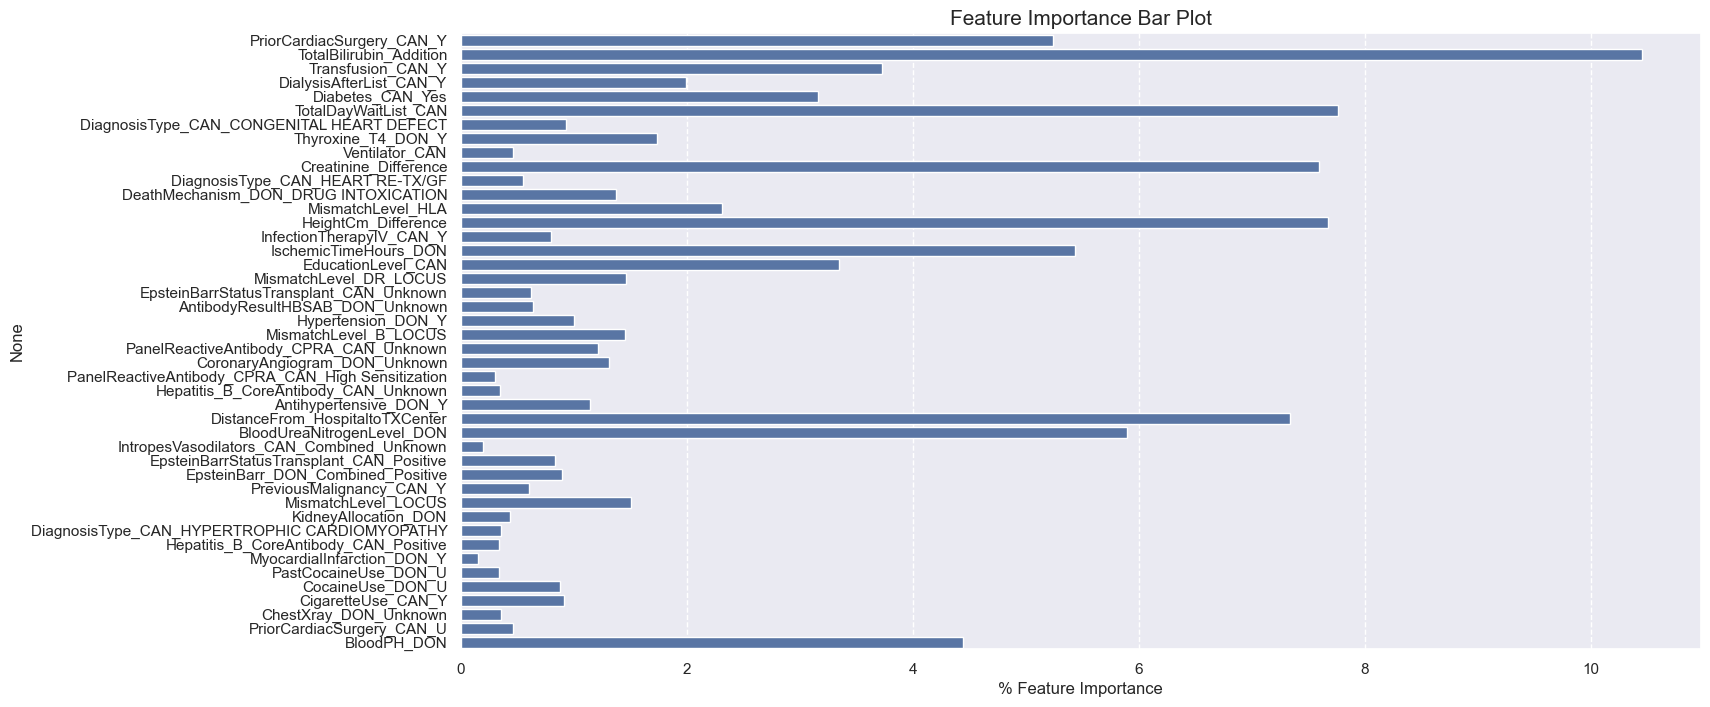

In [22]:
# plot
df_rfc = plotFeatureImportance(model, X_train[selected],figsize=(16,8))

***** Classfication Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.80      0.86      8291
           1       0.31      0.63      0.42      1216

    accuracy                           0.78      9507
   macro avg       0.62      0.71      0.64      9507
weighted avg       0.86      0.78      0.81      9507



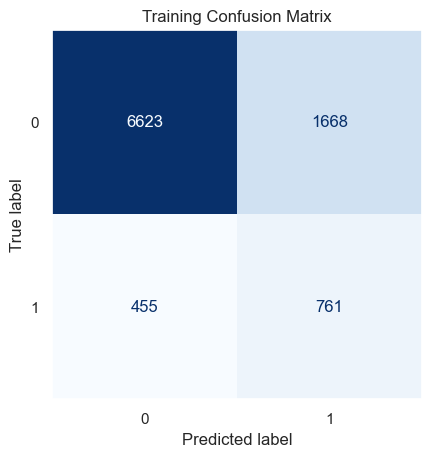

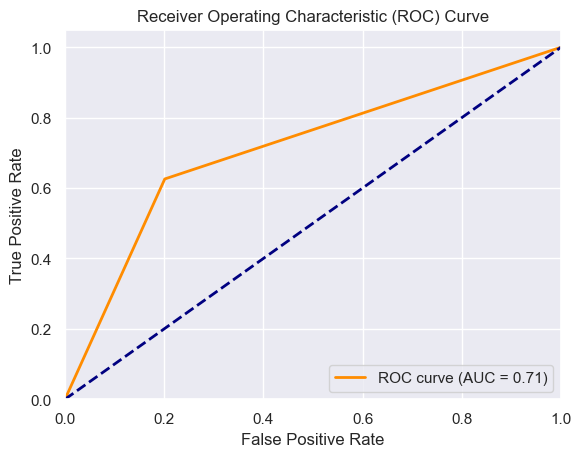

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_5_fit,RandomForestClassifier - Grid Search - Features where p_value <= 0.05,Training,0.776691,0.625822,0.417558,0.243928,0.313298,0.798818,0.71232


In [23]:
# display report - training
Specificity, RecallSensitivity, Accuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_train[selected], y_train, flag=False)

# initialize variable
Type = 'Training'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, Accuracy, Precision, F1, AveragePrecision, AUC)

# copy first metrics dataframe
df_classfication = df_metrics.copy()

# dispaly
df_classfication

***** Classfication Metrics for Validation/Test:
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.78      0.83      2073
           1       0.20      0.38      0.26       304

    accuracy                           0.73      2377
   macro avg       0.55      0.58      0.55      2377
weighted avg       0.81      0.73      0.76      2377



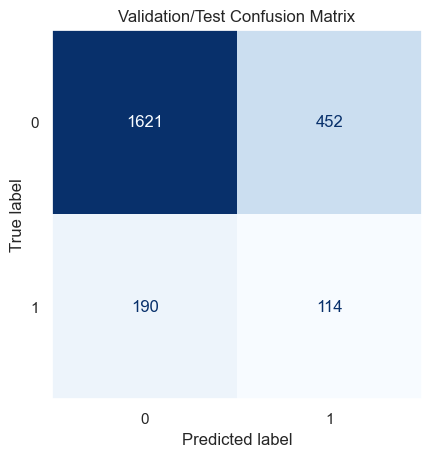

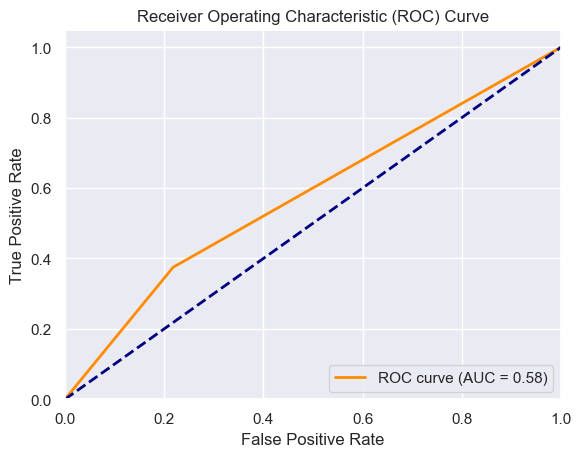

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_5_fit,RandomForestClassifier - Grid Search - Features where p_value <= 0.05,Training,0.776691,0.625822,0.417558,0.243928,0.313298,0.798818,0.712320
1,RandomForestClassifier,rfc_5_fit,RandomForestClassifier - Grid Search - Features where p_value <= 0.05,Validation,0.729912,0.375000,0.262069,0.155463,0.201413,0.781959,0.578479


In [24]:
# display report - validation
Specificity, RecallSensitivity, Accuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_val[selected], y_val, flag=True)

# initialize variable
Type = 'Validation'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, Accuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

#### BalancedRandomForestClassifier
- an adaptation of the Random Forest Classifier that takes into account the class imbalance problem during the learning process.

In [25]:
# import library
from imblearn.ensemble import BalancedRandomForestClassifier

# grid search Hyperparameters Random Forest Classfiier
parameters = {
    'n_estimators': [100, 300, 500],
    'min_samples_split': [30, 40, 50],
    'min_samples_leaf': [8, 10, 15],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 7]
}

brfc_param = {'class_weight': class_weight_dict, 'random_state': RANDOM_STATE, 'replacement' : True, 'bootstrap': True, 'sampling_strategy': 'all' }

# instantiate RandomForest Classifier
model = BalancedRandomForestClassifier(**brfc_param)

In [26]:
# initialize variables
Algorithm = 'BalancedRandomForestClassifier'
Desc = 'BalancedRandomForestClassifier - Grid Search - Features where p_value <= 0.05'
Model = 'brfc_5_fit'

# CV with grid search for Hyper-Parameter tuning
brfc_5_fit = stratified_grid(model, parameters, X_train[selected], y_train)

# best model
model = brfc_5_fit.best_estimator_

CV accuracy: 0.609 +/- 0.026


In [27]:
print(model)

BalancedRandomForestClassifier(bootstrap=True,
                               class_weight={0: 0.5733325292485828,
                                             1: 3.909128289473684},
                               max_depth=7, min_samples_leaf=15,
                               min_samples_split=40, n_estimators=500,
                               random_state=1776, replacement=True,
                               sampling_strategy='all')


                                                   % Feature Importance
Creatinine_Difference                                          9.447718
DistanceFrom_HospitaltoTXCenter                                9.331074
TotalBilirubin_Addition                                        9.187875
HeightCm_Difference                                            8.575360
TotalDayWaitList_CAN                                           8.141051
BloodUreaNitrogenLevel_DON                                     6.762915
IschemicTimeHours_DON                                          6.034642
BloodPH_DON                                                    5.045389
EducationLevel_CAN                                             3.762490
PriorCardiacSurgery_CAN_Y                                      3.398243
MismatchLevel_HLA                                              2.873245
Transfusion_CAN_Y                                              2.067313
Diabetes_CAN_Yes                                               1

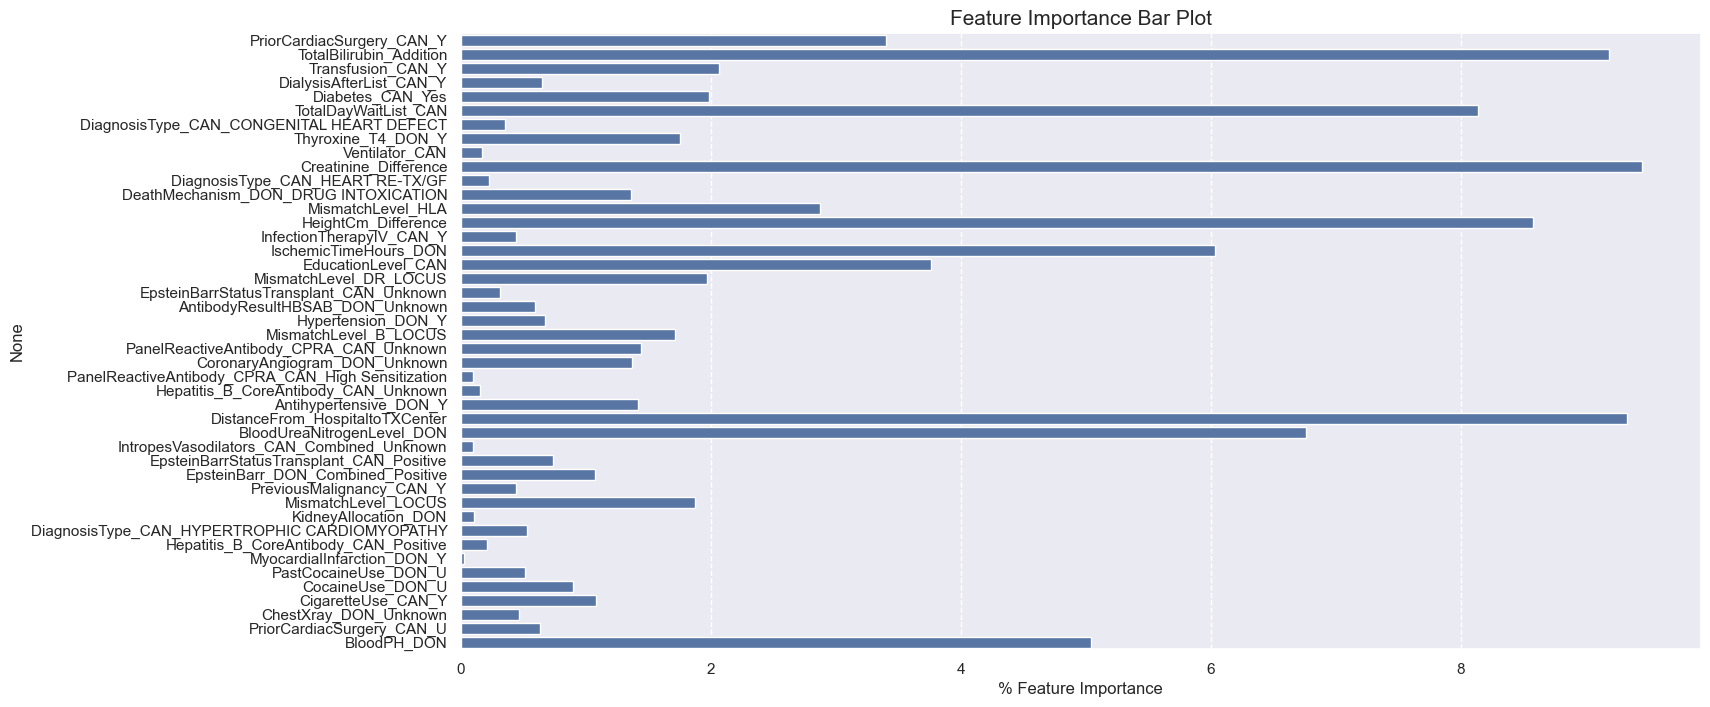

In [28]:
# plot
df_brfc = plotFeatureImportance(model, X_train[selected],figsize=(16,8))

***** Classfication Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      8291
           1       0.13      1.00      0.23      1216

    accuracy                           0.13      9507
   macro avg       0.06      0.50      0.11      9507
weighted avg       0.02      0.13      0.03      9507



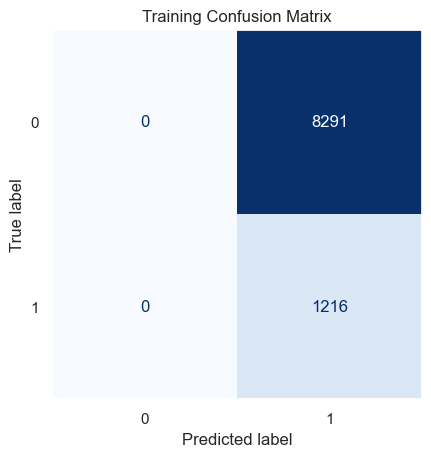

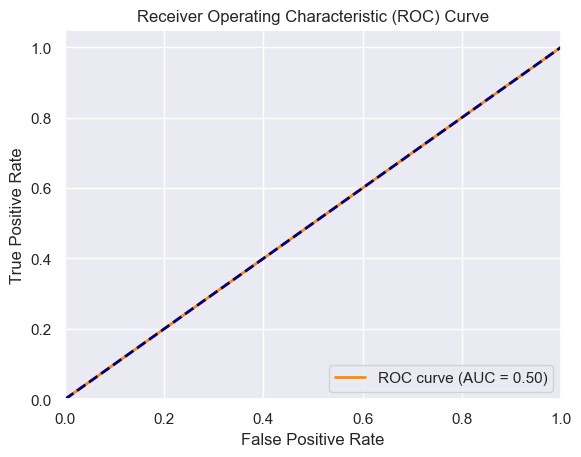

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_5_fit,RandomForestClassifier - Grid Search - Features where p_value <= 0.05,Training,0.776691,0.625822,0.417558,0.243928,0.313298,0.798818,0.712320
1,RandomForestClassifier,rfc_5_fit,RandomForestClassifier - Grid Search - Features where p_value <= 0.05,Validation,0.729912,0.375000,0.262069,0.155463,0.201413,0.781959,0.578479
2,BalancedRandomForestClassifier,brfc_5_fit,BalancedRandomForestClassifier - Grid Search - Features where p_value <= 0.05,Training,0.127906,1.000000,0.226802,0.127906,0.127906,0.000000,0.500000


In [29]:
# display report - training
Specificity, RecallSensitivity, Accuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_train[selected], y_train, flag=False)

# initialize variable
Type = 'Training'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, Accuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

***** Classfication Metrics for Validation/Test:
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      2073
           1       0.13      1.00      0.23       304

    accuracy                           0.13      2377
   macro avg       0.06      0.50      0.11      2377
weighted avg       0.02      0.13      0.03      2377



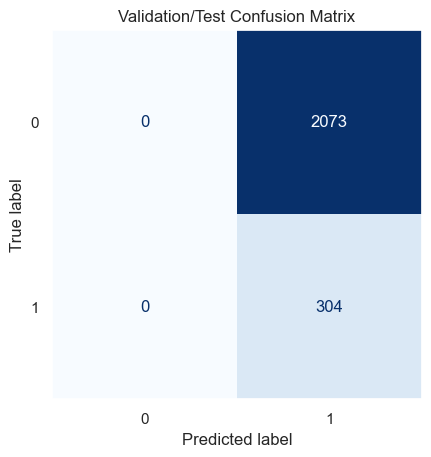

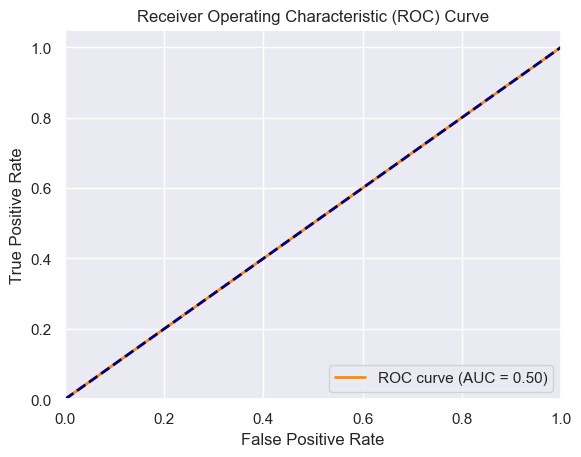

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_5_fit,RandomForestClassifier - Grid Search - Features where p_value <= 0.05,Training,0.776691,0.625822,0.417558,0.243928,0.313298,0.798818,0.712320
1,RandomForestClassifier,rfc_5_fit,RandomForestClassifier - Grid Search - Features where p_value <= 0.05,Validation,0.729912,0.375000,0.262069,0.155463,0.201413,0.781959,0.578479
2,BalancedRandomForestClassifier,brfc_5_fit,BalancedRandomForestClassifier - Grid Search - Features where p_value <= 0.05,Training,0.127906,1.000000,0.226802,0.127906,0.127906,0.000000,0.500000
3,BalancedRandomForestClassifier,brfc_5_fit,BalancedRandomForestClassifier - Grid Search - Features where p_value <= 0.05,Validation,0.127892,1.000000,0.226781,0.127892,0.127892,0.000000,0.500000


In [30]:
# display report - validation
Specificity, RecallSensitivity, Accuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_val[selected], y_val, flag=True)

# initialize variable
Type = 'Validation'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, Accuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

### Logistic Regression

In [31]:
# import library
from sklearn.linear_model import LogisticRegression

# define the hyperparameter grid to search
parameters = dict(
C = list(np.round(np.linspace(0.01, 5, 20),2))
)

# Base Model
lrc_param = {'max_iter':10000, 'class_weight': class_weight_dict, 'random_state': RANDOM_STATE}

# instantiate LogisticRegression Classifier
model = LogisticRegression(**lrc_param)

In [32]:
# initialize variables
Algorithm = 'LogisticRegression'
Desc = 'LogisticRegression - Grid Search - Features where p_value <= 0.05'
Model = 'lrc_5_fit'

# CV with grid search for Hyper-Parameter tuning
lrc_5_fit = stratified_grid(model, parameters, X_train[selected], y_train, nSplit=5)

# best model
model = lrc_5_fit.best_estimator_

CV accuracy: 0.633 +/- 0.028


/opt/homebrew/Caskroom/miniconda/base/envs/survival_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


***** Classfication Metrics for Validation/Test:
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.62      0.74      8291
           1       0.19      0.61      0.29      1216

    accuracy                           0.62      9507
   macro avg       0.55      0.61      0.51      9507
weighted avg       0.82      0.62      0.68      9507



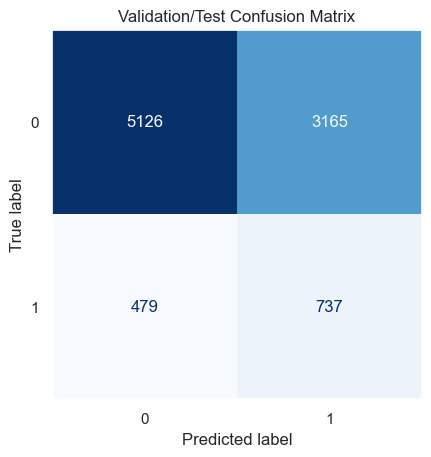

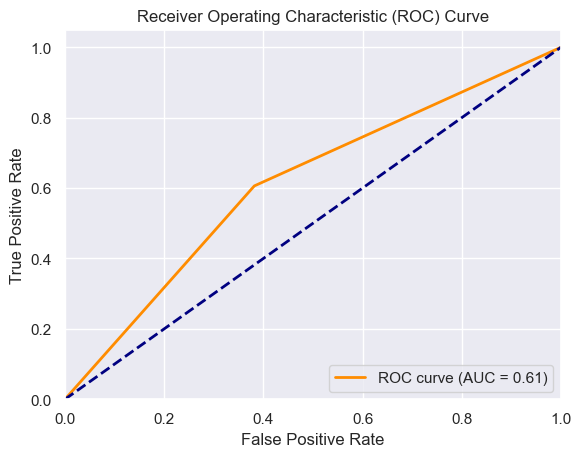

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_5_fit,RandomForestClassifier - Grid Search - Features where p_value <= 0.05,Training,0.776691,0.625822,0.417558,0.243928,0.313298,0.798818,0.712320
1,RandomForestClassifier,rfc_5_fit,RandomForestClassifier - Grid Search - Features where p_value <= 0.05,Validation,0.729912,0.375000,0.262069,0.155463,0.201413,0.781959,0.578479
2,BalancedRandomForestClassifier,brfc_5_fit,BalancedRandomForestClassifier - Grid Search - Features where p_value <= 0.05,Training,0.127906,1.000000,0.226802,0.127906,0.127906,0.000000,0.500000
3,BalancedRandomForestClassifier,brfc_5_fit,BalancedRandomForestClassifier - Grid Search - Features where p_value <= 0.05,Validation,0.127892,1.000000,0.226781,0.127892,0.127892,0.000000,0.500000
4,LogisticRegression,lrc_5_fit,LogisticRegression - Grid Search - Features where p_value <= 0.05,Training,0.616703,0.606086,0.288003,0.164860,0.188877,0.618261,0.612173


In [33]:
# display report - training
Specificity, RecallSensitivity, Accuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_train[selected], y_train, flag=True)

# initialize variable
Type = 'Training'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, Accuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

***** Classfication Metrics for Validation/Test:
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.63      0.74      2073
           1       0.17      0.52      0.25       304

    accuracy                           0.61      2377
   macro avg       0.53      0.57      0.50      2377
weighted avg       0.80      0.61      0.68      2377



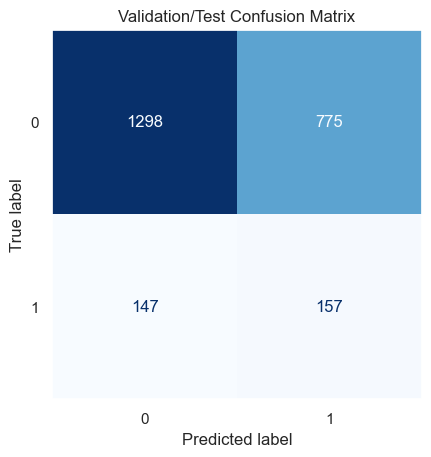

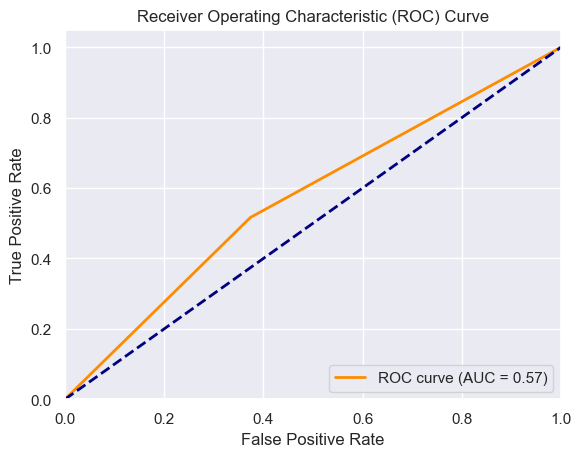

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_5_fit,RandomForestClassifier - Grid Search - Features where p_value <= 0.05,Training,0.776691,0.625822,0.417558,0.243928,0.313298,0.798818,0.712320
1,RandomForestClassifier,rfc_5_fit,RandomForestClassifier - Grid Search - Features where p_value <= 0.05,Validation,0.729912,0.375000,0.262069,0.155463,0.201413,0.781959,0.578479
2,BalancedRandomForestClassifier,brfc_5_fit,BalancedRandomForestClassifier - Grid Search - Features where p_value <= 0.05,Training,0.127906,1.000000,0.226802,0.127906,0.127906,0.000000,0.500000
3,BalancedRandomForestClassifier,brfc_5_fit,BalancedRandomForestClassifier - Grid Search - Features where p_value <= 0.05,Validation,0.127892,1.000000,0.226781,0.127892,0.127892,0.000000,0.500000
4,LogisticRegression,lrc_5_fit,LogisticRegression - Grid Search - Features where p_value <= 0.05,Training,0.616703,0.606086,0.288003,0.164860,0.188877,0.618261,0.612173
5,LogisticRegression,lrc_5_fit,LogisticRegression - Grid Search - Features where p_value <= 0.05,Validation,0.612116,0.516447,0.254045,0.148841,0.168455,0.626146,0.571297


In [34]:
# display report - validation
Specificity, RecallSensitivity, Accuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_val[selected], y_val, flag=True)

# initialize variable
Type = 'Validation'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, Accuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

#### XGBoost

In [35]:
# import library
from xgboost import XGBClassifier

# calculate the scale_pos_weight to adjust for class imbalance
# helps to counteract the imbalance by giving more weight to the minority class (usually the positive class in binary classification).
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# define the hyperparameter grid to search
parameters = dict(
n_estimators = [100, 200, 400],
max_depth = [3,7,10],
learning_rate = [0.05, 0.1, 0.3],
subsample = [0.6, 0.8, 1.0],
# colsample_bytree = colsample_bytree,
# min_child_weight = min_child_weight,
gamma = [0.2, 0.4] # regularization term that controls the minimum loss reduction required to make a split at a node.
)

# Base Model
xgb_param = {'scale_pos_weight': scale_pos_weight, 'n_jobs': -1,'random_state': RANDOM_STATE}

# instantiate XGB Classifier
model = XGBClassifier(**xgb_param)

In [36]:
# initialize variables
Algorithm = 'XGBClassifier'
Desc = 'XGBClassifier - Grid Search - Features where p_value <= 0.05'
Model = 'xgb_5_fit'


# CV with grid search for Hyper-Parameter tuning
xgb_5_fit = stratified_grid(model, parameters, X_train[selected], y_train, nSplit=5)

# best model
model = xgb_5_fit.best_estimator_

CV accuracy: 0.616 +/- 0.030


/opt/homebrew/Caskroom/miniconda/base/envs/survival_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [37]:
print(model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, random_state=1776, ...)


                                                   % Feature Importance
Transfusion_CAN_Y                                              4.540893
PriorCardiacSurgery_CAN_Y                                      4.311619
Diabetes_CAN_Yes                                               3.768286
MismatchLevel_LOCUS                                            2.764780
Antihypertensive_DON_Y                                         2.642056
EpsteinBarr_DON_Combined_Positive                              2.613657
EpsteinBarrStatusTransplant_CAN_Positive                       2.524627
PanelReactiveAntibody_CPRA_CAN_Unknown                         2.509009
DiagnosisType_CAN_HEART RE-TX/GF                               2.507331
TotalBilirubin_Addition                                        2.497341
Creatinine_Difference                                          2.492619
DialysisAfterList_CAN_Y                                        2.482679
CoronaryAngiogram_DON_Unknown                                  2

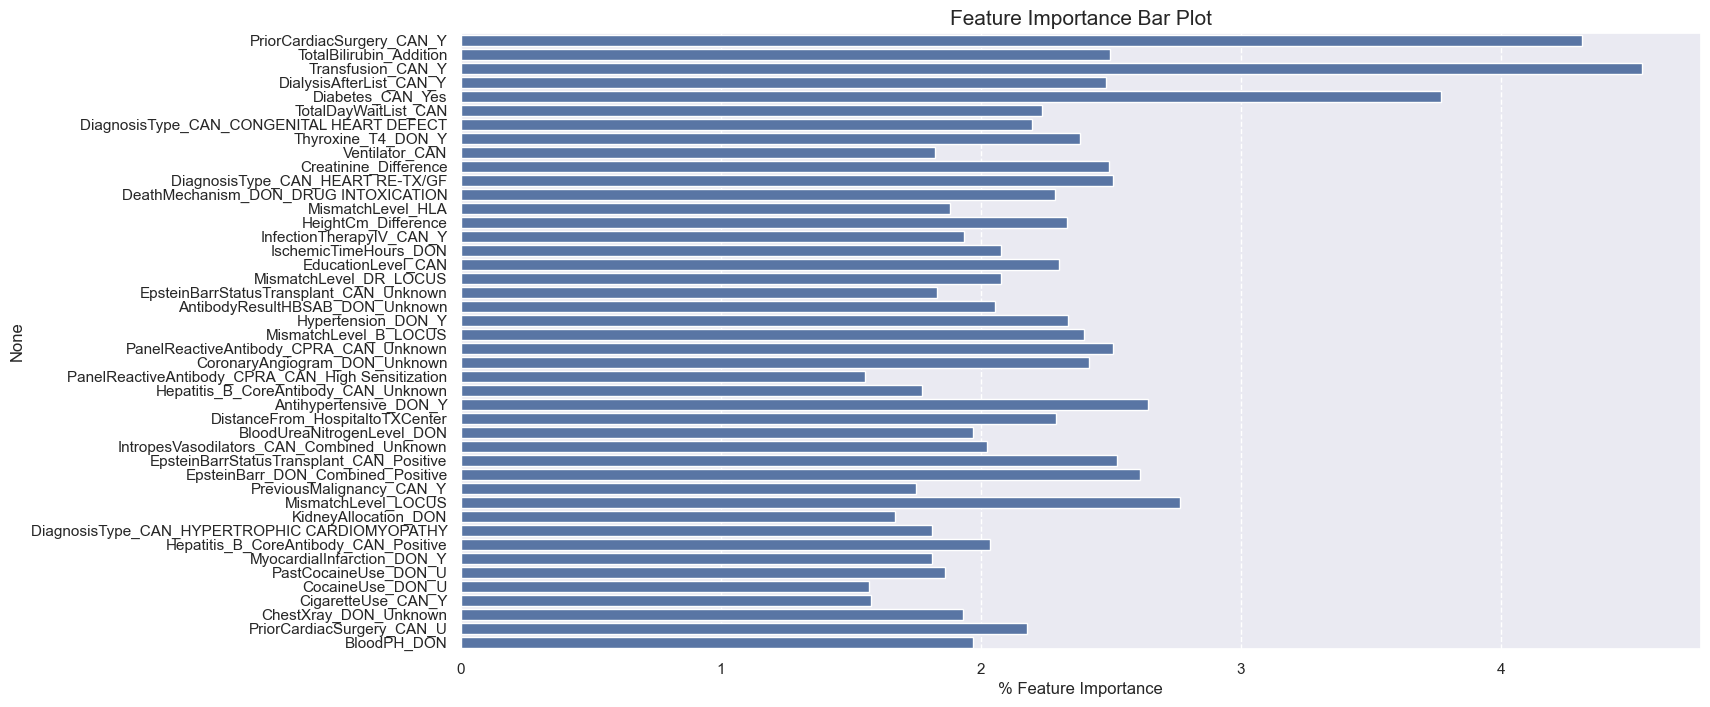

In [38]:
# plot
df_xgb = plotFeatureImportance(model, X_train[selected],figsize=(16,8))

***** Classfication Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.72      0.82      8291
           1       0.27      0.71      0.39      1216

    accuracy                           0.72      9507
   macro avg       0.61      0.71      0.60      9507
weighted avg       0.86      0.72      0.76      9507



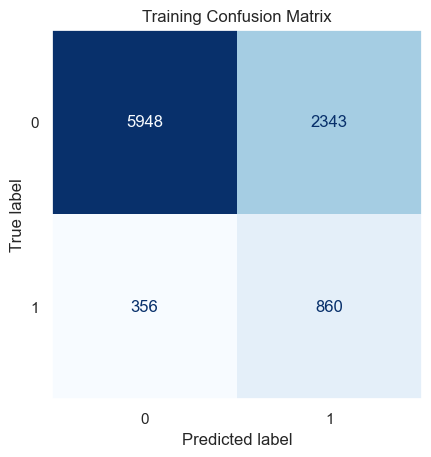

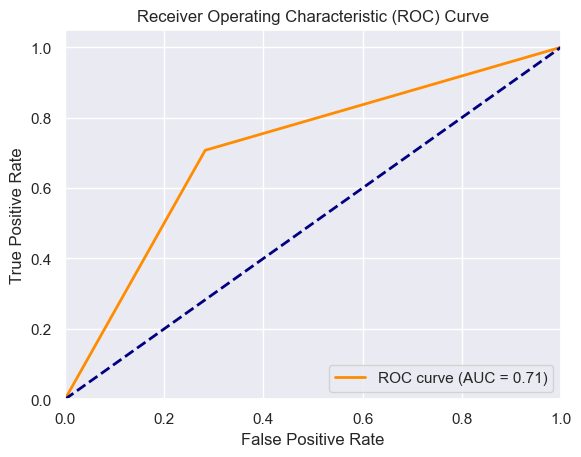

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_5_fit,RandomForestClassifier - Grid Search - Features where p_value <= 0.05,Training,0.776691,0.625822,0.417558,0.243928,0.313298,0.798818,0.712320
1,RandomForestClassifier,rfc_5_fit,RandomForestClassifier - Grid Search - Features where p_value <= 0.05,Validation,0.729912,0.375000,0.262069,0.155463,0.201413,0.781959,0.578479
2,BalancedRandomForestClassifier,brfc_5_fit,BalancedRandomForestClassifier - Grid Search - Features where p_value <= 0.05,Training,0.127906,1.000000,0.226802,0.127906,0.127906,0.000000,0.500000
3,BalancedRandomForestClassifier,brfc_5_fit,BalancedRandomForestClassifier - Grid Search - Features where p_value <= 0.05,Validation,0.127892,1.000000,0.226781,0.127892,0.127892,0.000000,0.500000
4,LogisticRegression,lrc_5_fit,LogisticRegression - Grid Search - Features where p_value <= 0.05,Training,0.616703,0.606086,0.288003,0.164860,0.188877,0.618261,0.612173
5,LogisticRegression,lrc_5_fit,LogisticRegression - Grid Search - Features where p_value <= 0.05,Validation,0.612116,0.516447,0.254045,0.148841,0.168455,0.626146,0.571297
6,XGBClassifier,xgb_5_fit,XGBClassifier - Grid Search - Features where p_value <= 0.05,Training,0.716104,0.707237,0.389228,0.227338,0.268498,0.717404,0.712321


In [39]:
# display report - training
Specificity, RecallSensitivity, Accuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_train[selected], y_train, flag=False)

# initialize variable
Type = 'Training'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, Accuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

***** Classfication Metrics for Validation/Test:
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.69      0.78      2073
           1       0.19      0.49      0.27       304

    accuracy                           0.67      2377
   macro avg       0.55      0.59      0.53      2377
weighted avg       0.81      0.67      0.72      2377



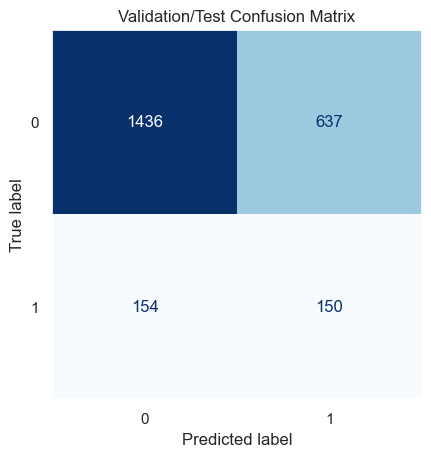

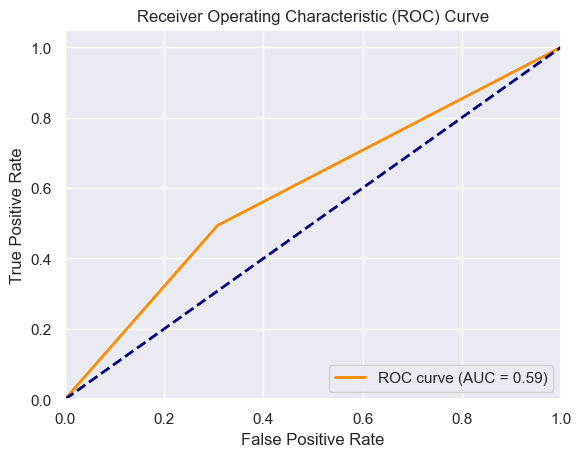

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_5_fit,RandomForestClassifier - Grid Search - Features where p_value <= 0.05,Training,0.776691,0.625822,0.417558,0.243928,0.313298,0.798818,0.712320
1,RandomForestClassifier,rfc_5_fit,RandomForestClassifier - Grid Search - Features where p_value <= 0.05,Validation,0.729912,0.375000,0.262069,0.155463,0.201413,0.781959,0.578479
2,BalancedRandomForestClassifier,brfc_5_fit,BalancedRandomForestClassifier - Grid Search - Features where p_value <= 0.05,Training,0.127906,1.000000,0.226802,0.127906,0.127906,0.000000,0.500000
3,BalancedRandomForestClassifier,brfc_5_fit,BalancedRandomForestClassifier - Grid Search - Features where p_value <= 0.05,Validation,0.127892,1.000000,0.226781,0.127892,0.127892,0.000000,0.500000
4,LogisticRegression,lrc_5_fit,LogisticRegression - Grid Search - Features where p_value <= 0.05,Training,0.616703,0.606086,0.288003,0.164860,0.188877,0.618261,0.612173
5,LogisticRegression,lrc_5_fit,LogisticRegression - Grid Search - Features where p_value <= 0.05,Validation,0.612116,0.516447,0.254045,0.148841,0.168455,0.626146,0.571297
6,XGBClassifier,xgb_5_fit,XGBClassifier - Grid Search - Features where p_value <= 0.05,Training,0.716104,0.707237,0.389228,0.227338,0.268498,0.717404,0.712321
7,XGBClassifier,xgb_5_fit,XGBClassifier - Grid Search - Features where p_value <= 0.05,Validation,0.667228,0.493421,0.274977,0.158832,0.190597,0.692716,0.593068


In [40]:
# display report - validation
Specificity, RecallSensitivity, Accuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_val[selected], y_val, flag=True)

# initialize variable
Type = 'Validation'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, Accuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

##### Metrics
- `Accuracy` is a metric used to evaluate the performance of a classification model. It measures the proportion of correct predictions out of the total predictions made.
- `Recall`, also known as `Sensitivity` or `True Positive Rate` (TPR), is a metric used to evaluate the performance of a classification model, particularly in situations where correctly identifying positive cases
- The `F1 score` is the harmonic mean of `precision` and `recall`. It ranges from 0 to 1, where 1 indicates the best possible performance.
- `Average Precision` calculates the area under the precision-recall curve by averaging precision values at increasing recall levels.
- `Precision` is a metric used to evaluate the accuracy of positive predictions in a classification model, particularly useful in binary classification tasks. It measures how many of the instances predicted as positive are actually positive.
- `Specificity` (also known as the `True Negative Rate`) is a metric used in binary classification to measure the model’s ability to correctly identify negative instances. It tells us the proportion of actual negatives that were correctly classified as negative by the model.
- The `ROC AUC score` is a performance metric for classification models, particularly useful for evaluating models in binary classification tasks. It combines Receiver Operating Characteristic (ROC) curve analysis with the Area Under the Curve (AUC).
    -  The area under the ROC curve (AUC) provides a single value summary of the model's ability to discriminate between positive and negative classes. It ranges from 0 to 1, where:
    - AUC = 1: Perfect classifier (it perfectly separates positive and negative classes).
    - AUC = 0.5: Model has no discrimination ability (equivalent to random guessing).
    - AUC < 0.5: The model performs worse than random guessing (this suggests the model may need to be inverted or there’s an issue with the model).